In [130]:
import pandas as pd
import xml.etree.ElementTree as et
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from py2neo import Graph, Node, Relationship
import matplotlib.pyplot as plt
from pandas import Series,DataFrame
plt.style.use('ggplot')
import seaborn as sns
plt.figure(figsize=(12, 6))
import geopandas as gp
from shapely.geometry import Polygon

<Figure size 864x432 with 0 Axes>

In [2]:
engine = create_engine('sqlite:///db_proj.db')

In [5]:
def parse_Xml(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    print(xroot)
    rows = []
    
    for node in xroot: 
        res = []
        #res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[0:]: 
            if node is not None:
                #res.append(node.find(el).text)
                res.append(node.attrib.get(el))
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [6]:
df_cols = ["Id","Reputation","CreationDate","DisplayName","LastAccessDate","WebsiteUrl","Location","AboutMe","Views","UpVotes","DownVotes","AccountId","ProfileImageUrl"]
df_users = parse_Xml("Users.xml",df_cols)

<Element 'users' at 0x0000017ABF0818B8>


,Id,Reputation,CreationDate,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,ProfileImageUrl
0,-1,1,2014-05-13T21:29:22.820,Community,2014-05-13T21:29:22.820,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",0,798,1325,-1,None
1,1,101,2014-05-13T22:58:54.810,Adam Lear,2019-06-11T19:12:27.157,None,"New York, NY",\n\n<p>Developer at Stack Overflow focusing on...,453,0,0,37099,https://i.stack.imgur.com/SMEGn.jpg?s=128&g=1
2,2,101,2014-05-13T22:59:19.787,Geoff Dalgas,2017-12-19T18:52:19.423,http://stackoverflow.com,"Corvallis, OR",<p>Developer on the Stack Overflow team. Find...,9,0,0,2,https://i.stack.imgur.com/nDllk.png
3,3,101,2014-05-13T23:15:34.483,hichris123,2019-08-01T18:06:24.597,None,None,<p>I'm a student interested in technology.</p>...,7,1,3,3046327,https://i.stack.imgur.com/JVj4n.png?s=256&g=1
4,4,101,2014-05-13T23:16:09.937,Ben Collins,2014-08-04T15:25:54.810,http://benjamincollins.com,Republic of Texas,"<p>I work with <a href=""https://olo.com"" rel=""...",9,0,0,2365,None


In [25]:
df_users.to_sql('Users', engine, if_exists='append')

In [3]:
conn = sqlite3.connect('db_proj.db')

In [16]:
cols = ["Id","UserId","Name","Date","Class","TagBased"]
df_badges = parse_Xml("Badges.xml",cols)
df_badges.to_sql("Badges",engine,if_exists="append")

<Element 'badges' at 0x0000027A0CDB5048>


In [30]:
df_badges.to_sql("Badges",engine,if_exists = "append")

In [34]:
%%time
df_cols = ["Id","PostHistoryTypeId","PostId","RevisionGUID","CreationDate","UserId","Text","Comment","UserDisplayName"]
df_posthis = parse_Xml("PostHistory.xml",df_cols)

<Element 'posthistory' at 0x000001D04BBE69A8>
Wall time: 4.55 s


In [36]:
df_posthis.to_sql("PostHistory",engine,if_exists = "append")

In [7]:
cols_df = ["Id","CreationDate","PostId","RelatedPostId","LinkTypeId"]
df_postlink = parse_Xml("PostLinks.xml",cols_df)

<Element 'postlinks' at 0x0000017ABEDE9958>


In [39]:
cols_df = ["Id","PostTypeId","CreationDate","Score","ViewCount","Body","OwnerUserId","LastActivityDate","Title","Tags","AnswerCount","CommentCount","FavouriteCount","CLosedDate","AcceptedAnswerId","LastEditorUserId","DisplayName","OwnerDisplayName"]
df_posts = parse_Xml("Posts.xml",cols_df)

<Element 'posts' at 0x000001D05A4CA318>


In [40]:
df_posts.to_sql("Posts",engine,if_exists="append")

In [41]:
cols = ["Id","PostId","Vote","VoteTypeId","CreationDate","UserId","BountyAmount"]
df_votes = parse_Xml("Votes.xml",cols)

<Element 'votes' at 0x000001D05723F638>


In [42]:
df_votes.to_sql("Votes",engine,if_exists="append")

In [43]:
cols = ["Id","TagName","Count","ExcerptPostId","WikiPostId"]
df_tags = parse_Xml("Tags.xml",cols)
df_tags.to_sql("Tags",engine,if_exists="append")

<Element 'tags' at 0x000001D05A6A3AE8>


In [44]:
cols = ["Id","PostId","Score","Text","CreationDate","UserId","UserDisplayName"]
df_comments = parse_Xml("Comments.xml",cols)
df_comments.to_sql("Comments",engine,if_exists="append")

<Element 'comments' at 0x000001D04F744B38>


In [48]:
%%time
uri = "bolt://localhost:7687"
user = "neo4j"
password = "9936"
graph = Graph(uri = uri, user = user, password = password)
graph.delete_all
tx = graph.begin()


for i in range(len(df_postlink)):
    src = Node('Posts', name = str(df_postlink['PostId'][i]),id = str(df_postlink['PostId'][i]))
    tx.merge(src,'Posts','name')
    trg = Node('Posts', name = str(df_postlink['RelatedPostId'][i]), id = str(df_postlink['RelatedPostId'][i]))
    tx.merge(trg,'Posts', 'name')
    rel = Relationship(src, str(df_postlink['LinkTypeId'][i]),trg)
    tx.create(rel)

tx.commit()

In [6]:
df_users = pd.read_sql_query("select * from Users",conn)

In [62]:
df = pd.read_sql_query('select count(*) as count,Name from Badges group by Name order by count desc limit 10',conn)

In [33]:
df = pd.read_sql_query('select * from Posts',conn)

In [20]:
df = pd.read_sql_query('select * from Badges where Name = "Tumbleweed"',conn)

In [82]:
%%time
df['CreationDate'] =  pd.to_datetime(df['CreationDate'])

Wall time: 67.8 ms


In [28]:
df['Dates'] = df['Date'].dt.date

In [29]:
df['Time'] = df['Date'].dt.time

In [32]:
df.head()

,index,Id,UserId,Name,Class,TagBased,Dates,Time
0,0,1,1,Informed,3,False,2014-05-13,23:06:44.683000
1,1,2,2,Autobiographer,3,False,2014-05-13,23:11:04.153000
2,2,3,4,Autobiographer,3,False,2014-05-13,23:20:53.547000
3,3,4,5,Autobiographer,3,False,2014-05-13,23:20:53.547000
4,4,5,8,Autobiographer,3,False,2014-05-13,23:20:53.547000


In [43]:
df_post = pd.read_sql_query('select * from Posts order by Score desc limit 10',conn)

In [26]:
df = pd.read_sql_query('select * from Posts',conn)

In [25]:
df['OwnerUserId'] = df_post['OwnerUserId']

NameError: name 'df_post' is not defined

In [58]:
df_merge_col = pd.merge(df, df_post, on='OwnerUserId')

In [61]:
df_merge_col[['Score','Name','Class']]

,Score,Name,Class
0,98,Informed,3
1,95,Autobiographer,3
2,90,Autobiographer,3
3,9,Autobiographer,3
4,9,Autobiographer,3
5,9,Autobiographer,3
6,9,Autobiographer,3
7,9,Autobiographer,3
8,9,Autobiographer,3
9,9,Informed,3


In [21]:
df_badge = df[['UserId','Name','Date','Class']]

In [22]:
df_badge=df_badge[df_badge['Name'] == 'Tumbleweed']

In [73]:
df_badge['Date'] = pd.to_datetime(df_badge['Date']) 

C:\Users\NITJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [27]:
df_2 = df[df['Score'] <= "10"]['OwnerUserId']

In [28]:
df_2 = df_2.unique()

In [29]:
df_2 = list(df_2)

In [30]:
len(df_2)

10208

In [31]:
df_=pd.read_sql_query('select * from Badges where Name = "Tumbleweed"',conn)

In [32]:
df_1 = df_['UserId']

In [33]:
list1 = []
list1 = df_['UserId']

In [34]:
list1 = list1.unique()

In [35]:
len(list1)

2797

In [29]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

In [31]:
print(len(intersection(df_2,list1)))

1664


In [77]:
data = [{"Name" : "Tumbleweed", "%age" : float(1664/2797)*100} , {"Name" : "Others", "%age" : 100 - float(1664/2797)*100}]

In [78]:
df_all = pd.DataFrame(data)

In [79]:
df_all

,%age,Name
0,59.492313,Tumbleweed
1,40.507687,Others


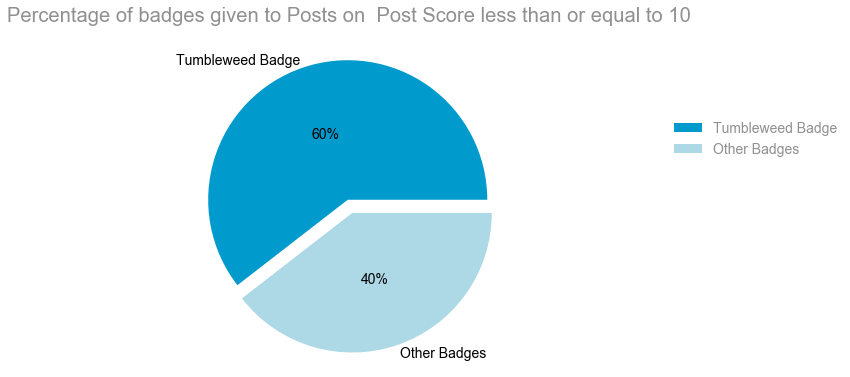

In [67]:
fig, ax = plt.subplots(figsize = (8,6))
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=14
color_palette_list = ['#009ACD', '#ADD8E6', '#63D1F4', '#0EBFE9',   
                      '#C1F0F6', '#0099CC']
labels = ['Tumbleweed Badge', 
         'Other Badges']
percentages = [60.49, 39.51]
explode=(0.1,0)
plt.rcParams['text.color'] = '#000000'
ax.pie(percentages, explode=explode, labels=labels,  
       colors=color_palette_list[0:2], autopct='%1.0f%%', 
       shadow=False, startangle=0,   
       pctdistance=0.5,labeldistance=1.06)
plt.rcParams['text.color'] = '#909090'
ax.axis('equal')
ttl = ax.set_title("Percentage of badges given to Posts on  Post Score less than or equal to 10")
ttl.set_position([.5, 1.05])
ax.legend(frameon=False, bbox_to_anchor=(1.2,0.8))

In [14]:
df_users=pd.read_sql_query('select * from Users',conn)

In [113]:
df = df[(df['UpVotes'] > "1") & (df['DownVotes'] == "0")]

In [180]:
df_1upv = df[['Id','UpVotes','DownVotes']]

In [182]:
len(df_1upv)

3921

In [38]:
df_posts = pd.read_sql_query('select * from Posts',conn)

In [191]:
data = []
for i in df_1upv['Id']:
    count = 0
    for j in df_posts['OwnerUserId']:
        if i==j:
            count+=1
    data.append(count)        
          

match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
matc

match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
matc

match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
match
matc

In [192]:
df_1upv['count'] = data

C:\Users\NITJ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
data2 = []
for i in list1:
    count = 0
    for j in df_posts['OwnerUserId']:
        if i==j:
            count+=1
    data2.append(count)

3.9481587415087596
Inter Quartile Range : 3.0
Q2(median) : 1.0
Q1: 0.0
Q3: 3.0
Upper whisker: 4.5
Lower whisker: 7.5
No of outliers: 2617


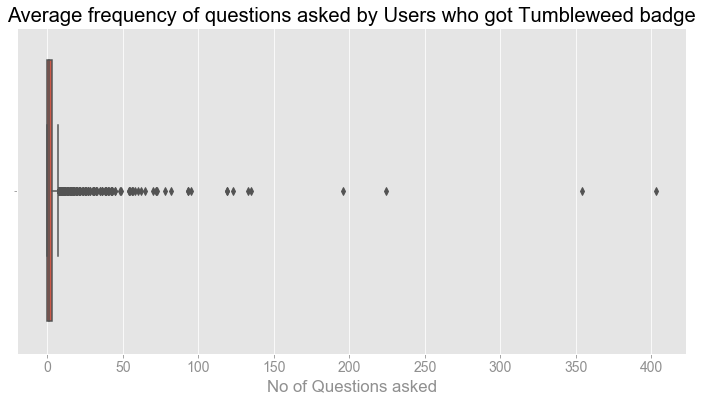

In [104]:
import statistics
plt.figure(figsize=(12, 6))
print(statistics.mean(data2))
sns.boxplot(data2,orient = 'Vertical').set(xlabel = 'No of Questions asked')
plt.title("Average frequency of questions asked by Users who got Tumbleweed badge")
q1=np.percentile(np.array(data2),25)
q2=np.percentile(np.array(data2),50)
q3=np.percentile(np.array(data2),75)
outlier = []
iqr = q3-q1
outlier1=1.5*iqr - q1
outlier2=1.5*iqr + q3
for items in data2:
    if (items < outlier1 or items > outlier2):
        outlier.append(items)
print('Inter Quartile Range :', iqr)
print('Q2(median) :',q2)
print('Q1:',q1)
print('Q3:',q3)
print('Upper whisker:',outlier1)
print('Lower whisker:',outlier2)
print('No of outliers:',len(outlier))

In [98]:
df_users=pd.read_sql_query('select * from Users',conn)
df_users = df_users[(df_users['UpVotes'] > "0") & (df_users['DownVotes'] > "0")]
df_2upv = df_users[['Id','UpVotes','DownVotes']]
data1 = []
for i in df_2upv['Id']:
    count = 0
    for j in df_posts['OwnerUserId']:
        if i==j:
            count+=1
    data1.append(count) 

Inter Quartile Range: 27.0
Q2(median) : 13.0
Q1: 5.0
Q3: 32.0
Upper whisker: 35.5
Lower whisker: 72.5
No of outliers: 834


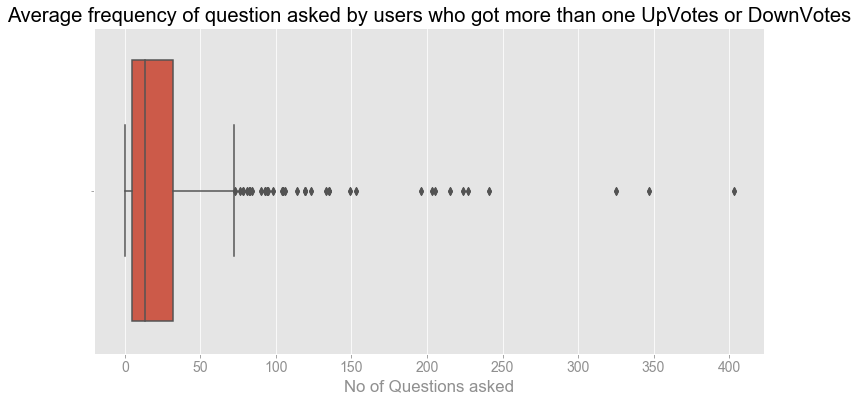

In [103]:
plt.figure(figsize=(12, 6))
sns.boxplot(data1,orient = 'Vertical').set(xlabel = 'No of Questions asked')
plt.title("Average frequency of question asked by users who got more than one UpVotes or DownVotes")
q1=np.percentile(np.array(data1),25)
q2=np.percentile(np.array(data1),50)
q3=np.percentile(np.array(data1),75)
outlier = []
iqr = q3-q1
outlier1=1.5*iqr - q1
outlier2=1.5*iqr + q3
for items in data1:
    if (items < outlier1 or items > outlier2):
        outlier.append(items)
print('Inter Quartile Range:', iqr)
print('Q2(median) :',q2)
print('Q1:',q1)
print('Q3:',q3)
print('Upper whisker:',outlier1)
print('Lower whisker:',outlier2)
print('No of outliers:',len(outlier))

In [51]:
userid = []
upvotes = []
downvotes = []
viewcount = []
reputation = []

for i in range(len(list1)):
    for j in range(len(df_users['Id'])):
        if list1[i] == df_users['Id'].iloc[j]:
            userid.append(df_users['Id'].iloc[j])
            upvotes.append(df_users['UpVotes'].iloc[j])
            downvotes.append(df_users['DownVotes'].iloc[j])
            viewcount.append(df_users['Views'].iloc[j])
            reputation.append(df_users['Reputation'].iloc[j])       

In [45]:
df_tw['UserId'] = userid
df_tw['UpVotes'] = upvotes
df_tw['DownVotes'] = downvotes
df_tw['ViewCount'] = viewcount
df_tw['Reputation'] = reputation

In [11]:
%%time
u_source = df_postlink['PostId'].unique().tolist()
u_target = df_postlink['RelatedPostId'].unique().tolist()
u_source.extend(u_target)
list_set = set(u_source)
Vertices_list = list(list_set)
Vertices_list.sort()
len(Vertices_list)

Wall time: 4 ms


2245

In [12]:
Edges_list = list(zip(df_postlink['PostId'],df_postlink['RelatedPostId']))
Edges_list.sort()
Edges_unique = list(dict.fromkeys(Edges_list))
len(Edges_unique)

1558

In [13]:
%%time
V = len(Vertices_list)

Adj_list = []
for s in range(V):
    Adj_list.append([])

for i in Edges_unique:
    a = Vertices_list.index(i[0])
    b = Vertices_list.index(i[1])
    Adj_list[a].append(i[1])

Wall time: 91.8 ms


In [14]:
adj_list = [item for ele in Adj_list for item in ele]

In [15]:
df_posts = pd.read_sql_query('select * from Posts',conn)

In [55]:
upvotes = list(map(int,upvotes))

In [56]:
print(statistics.mean(upvotes))

8.064354665713264


In [16]:
userid1 = []
for i in range(len(adj_list)):
    for j in range(len(df_posts['OwnerUserId'])):
        if adj_list[i] == df_posts['OwnerUserId'].iloc[j]:
            userid1.append(df_posts['OwnerUserId'].iloc[j])

In [37]:
userid2 = []
upvotes2 = []
downvotes2 = []
viewcount2 = []
reputation2 = []

for i in range(len(userid1)):
    for j in range(len(df_users['Id'])):
        if userid1[i] == df_users['Id'].iloc[j]:
            userid2.append(df_users['Id'].iloc[j])
            upvotes2.append(df_users['UpVotes'].iloc[j])
            downvotes2.append(df_users['DownVotes'].iloc[j])
            viewcount2.append(df_users['Views'].iloc[j])
            reputation2.append(df_users['Reputation'].iloc[j])

In [63]:
df_tw

,UserId,UpVotes,DownVotes,ViewCount,Reputation


In [38]:
df_twl['UserId'] = userid2
df_twl['UpVotes'] = upvotes2
df_twl['DownVotes'] = downvotes2
df_twl['ViewCount'] = viewcount2
df_twl['Reputation'] = reputation2

In [53]:
upvotes2 = list(map(int,upvotes2))
downvotes2 = list(map(int,downvotes2))
viewcount2 = list(map(int,viewcount2))
reputation2 = list(map(int,reputation2))

In [48]:
df_twl = pd.DataFrame(columns= ['UserId','UpVotes','DownVotes','ViewCount','Reputation'])
df_tw = pd.DataFrame(columns = ['UserId','UpVotes','DownVotes','ViewCount','Reputation'])

In [49]:
import statistics
upv = []
dwv = []
vc = []
rep = []
upv.append(statistics.mean(upvotes2))
dwv.append(statistics.mean(downvotes2))
vc.append(statistics.mean(viewcount2))
rep.append(statistics.mean(reputation2))
df_twl['DownVotes'] = dwv
df_twl['UpVotes'] = upv
df_twl['ViewCount'] = vc
df_twl['Reputation'] = rep

In [55]:
upvotes = list(map(int,upvotes))
downvotes = list(map(int,downvotes))
viewcount = list(map(int,viewcount))
reputation = list(map(int,reputation))

In [56]:
upv1 = []
dwv1 = []
vc1 = []
rep1 = []
upv1.append(statistics.mean(upvotes))
dwv1.append(statistics.mean(downvotes))
vc1.append(statistics.mean(viewcount))
rep1.append(statistics.mean(reputation))
df_tw['DownVotes'] = dwv1
df_tw['UpVotes'] = upv1
df_tw['ViewCount'] = vc1
df_tw['Reputation'] = rep1

In [88]:
df_twl['ViewCount'] = statistics.mean(viewcount2)

In [89]:
df_twl['Reputation'] = statistics.mean(reputation2)

In [74]:
upvotes = list(map(int,upvotes))
downvotes = list(map(int,downvotes))
viewcount = list(map(int,viewcount))
reputation = list(map(int,reputation))

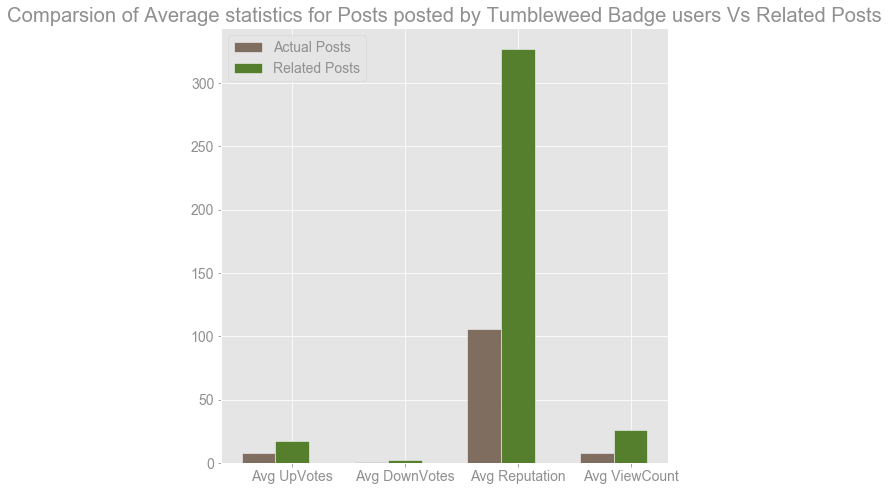

In [70]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.3
plt.figure(figsize=(8,8 ))
 
# set height of bar
bars1 = [df_tw['UpVotes'][0], df_tw['DownVotes'][0], df_tw['Reputation'][0], df_tw['ViewCount'][0]]
bars2 = [df_twl['UpVotes'][0], df_twl['DownVotes'][0], df_twl['Reputation'][0], df_twl['ViewCount'][0]]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#7f6d5f', width=barWidth, edgecolor='white', label='Actual Posts')
plt.bar(r2, bars2, color='#557f2d', width=barWidth, edgecolor='white', label='Related Posts')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars1))], ['Avg UpVotes', 'Avg DownVotes', 'Avg Reputation', 'Avg ViewCount'])
plt.title("Comparsion of Average statistics for Posts posted by Tumbleweed Badge users Vs Related Posts") 
# Create legend & Show graphic
plt.legend()
plt.show()


In [73]:
from bs4 import BeautifulSoup
import re
list_sent = []

s= df_posts.Body
for i in s:
    if i:
        sp = BeautifulSoup(i,'html.parser')
        for p in sp.findAll('p'):
            list_sent.append(p.text)

In [77]:
df_sent = pd.DataFrame(columns = ['Body','Sent_Polarity'])

In [78]:
body = []
for i in range(len(list1)):
    for j in range(len(df_posts['OwnerUserId'])):
        if list1[i] == df_posts['OwnerUserId'].iloc[j]:
            body.append(df_posts['Body'].iloc[j])

In [79]:
df_sent['Body'] = body

In [81]:
from textblob import TextBlob
df_sent['Sent_Polarity'] = df_sent['Body'].apply(lambda tweets : TextBlob(tweets).sentiment.polarity)

In [85]:
df_pos = df_sent[df_sent['Sent_Polarity'] > 0]
df_neg = df_sent[df_sent['Sent_Polarity'] < 0]

([<matplotlib.patches.Wedge at 0x17abbdc44a8>,
 [Text(-0.8618264185339201, 0.7764375211934289, 'Positive Sentiment'),
  Text(0.7875309711973312, -0.7095033258590043, 'Negative Sentiment')],
 [Text(-0.44577228544857933, 0.4016056144103943, '76.7%'),
  Text(0.37147687320628825, -0.33467138012217185, '23.3%')])

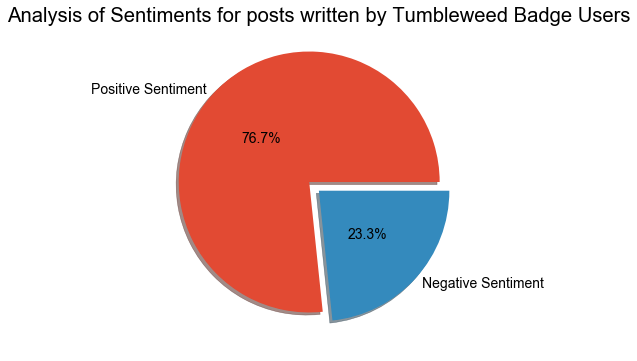

In [94]:
fig, ax = plt.subplots(figsize = (8,6))
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size']=14
labels = ['Positive Sentiment', 
         'Negative Sentiment']
plt.title("Analysis of Sentiments for posts written by Tumbleweed Badge Users")

ax.pie([len(df_pos) , len(df_neg)], explode = explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0,   
       pctdistance=0.5,labeldistance=1.06)


In [106]:
df_users

,index,Id,Reputation,CreationDate,DisplayName,LastAccessDate,WebsiteUrl,Location,AboutMe,Views,UpVotes,DownVotes,AccountId,ProfileImageUrl
0,0,-1,1,2014-05-13T21:29:22.820,Community,2014-05-13T21:29:22.820,http://meta.stackexchange.com/,on the server farm,"<p>Hi, I'm not really a person.</p>\n\n<p>I'm ...",0,798,1325,-1,None
3,3,3,101,2014-05-13T23:15:34.483,hichris123,2019-08-01T18:06:24.597,None,None,<p>I'm a student interested in technology.</p>...,7,1,3,3046327,https://i.stack.imgur.com/JVj4n.png?s=256&g=1
5,5,5,150,2014-05-13T23:16:11.013,Doorknob,2019-07-19T01:17:28.110,https://tck.mn/,"Texas, US","\n\n<p>Programmer, elected SE moderator ♦ on <...",27,1,2,1266491,https://i.stack.imgur.com/pqRUk.png?s=128&g=1
6,6,6,101,2014-05-13T23:16:26.517,gerrit,2019-08-28T10:42:03.333,http://www.topjaklont.org/,"Dietzenbach, Deutschland",<p>I'm a researcher in satellite remote sensin...,10,12,1,935589,https://i.stack.imgur.com/vAAS0.png?s=128&g=1
7,7,7,101,2014-05-13T23:17:05.443,Undo,2019-08-02T22:11:24.403,http://keybase.io/undo,None,"<p><a href=""//stackoverflow.com"">Stack Overflo...",4,2,1,1703573,None
17,17,18,101,2014-05-13T23:27:57.393,Gilles,2019-05-25T17:24:03.597,http://stackexchange.com/users/164368,None,"<p>Moderator♦ on <a href=""http://french.stacke...",1,12,2,164368,https://i.stack.imgur.com/cFyP6.jpg?s=128&g=1
19,19,20,101,2014-05-13T23:30:33.990,TheDoctor,2014-05-14T21:41:38.853,http://redteamgreen.blogspot.com/,The Future,<p>Timelord doge with Pythonic superpowers.</p...,1,1,1,3110483,https://i.stack.imgur.com/esQni.jpg?s=128&g=1
20,20,21,4426,2014-05-13T23:30:57.300,Sean Owen,2019-08-31T00:25:53.077,None,"Austin, TX, United States",None,1152,809,145,25066,None
21,21,22,303,2014-05-13T23:37:18.040,Nick Peterson,2019-04-01T21:57:52.150,http://nrpeterson.info,"San Mateo, CA",None,18,18,1,2876998,https://i.stack.imgur.com/TrZRT.jpg
25,25,26,2342,2014-05-13T23:41:54.430,Alex I,2019-07-11T21:30:37.137,None,None,None,98,55,3,2048845,https://i.stack.imgur.com/S6fiE.png?s=128&g=1


In [109]:
import pycountry
location = []
for i in range(len(list1)):
    for j in range(len(df_users['Id'])):
        if list1[i] == df_users['Id'].iloc[j]:
            location.append(df_users['Location'].iloc[j])

In [115]:
df_lo = pd.DataFrame(location, columns = ['Location'])

244

In [127]:
df_lo = df_lo.mask(df_lo.eq('None')).dropna()

In [128]:
location_new = df_lo['Location'].tolist()

In [145]:
countries = []
for text in location_new:
    for country in pycountry.countries:
        if country.name in text:
            countries.append(country.name)
        

In [131]:
shp = gp.GeoDataFrame.from_file('gadm36.shp')

In [146]:
df_lo = pd.DataFrame(countries, columns = ['Location'])

In [147]:
countries_new = df_lo['Location'].tolist()

In [148]:
countries_new = []
countries_new = df_lo['Location'].unique()

In [149]:
countries_new

array(['Singapore', 'Belarus', 'United Kingdom', 'Belgium', 'Canada',
       'India', 'France', 'United States', 'Israel', 'Australia',
       'Hungary', 'Portugal', 'Switzerland', 'Greece', 'Germany',
       'Netherlands', 'Argentina', 'Italy', 'Spain', 'Brazil', 'Colombia',
       'Japan'], dtype=object)

In [165]:
geometry = []
countries_all = []
for j in range(len(shp['NAME_0'])):
    for i in range(len(countries_new)):
        if countries_new[i] == shp['NAME_0'].iloc[j]:
            geometry.append(shp['geometry'].iloc[j])
            countries_all.append(shp['NAME_0'].iloc[j])
            break

In [172]:
shp_new = gp.GeoDataFrame(columns=['Locations','geometry'])

In [173]:
shp_new['Locations'] = countries_all
shp_new['geometry'] = geometry

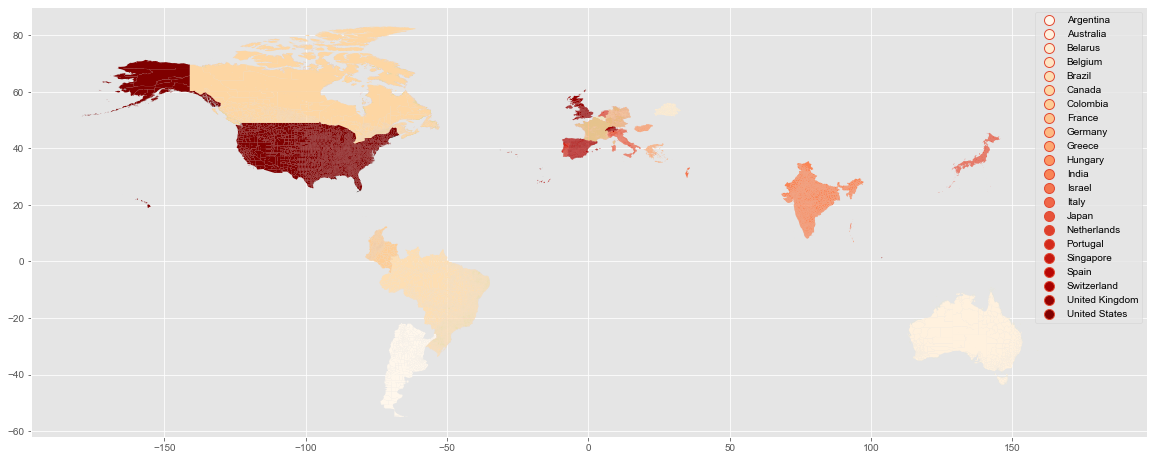

In [181]:
fig, ax = plt.subplots(figsize = (20,20))
shp_new['coords'] = shp_new['geometry'].apply(lambda x: x.representative_point().coords[:])
shp_new['coords'] = [coords[0] for coords in shp_new['coords']]
shp_new.plot(figsize=(20,20),column = 'Locations',legend = True,cmap = 'OrRd',ax=ax)

plt.show()